In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
from sklearn import datasets
import tarfile
data_home = datasets.get_data_home()
archive_path = os.path.join(data_home, 'cal_housing.tgz')
with tarfile.open(mode="r:gz", name=archive_path) as f:
     cal_housing = np.loadtxt(
         f.extractfile("CaliforniaHousing/cal_housing.data"), delimiter=","
     )
     # Columns are not in the same order compared to the previous
     # URL resource on lib.stat.cmu.edu
     columns_index = [8, 7, 2, 3, 4, 5, 6, 1, 0]
     cal_housing = cal_housing[:, columns_index]
       
feature_names = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
    "Latitude",
    "Longitude",
]

target, data = cal_housing[:, 0], cal_housing[:, 1:]

# avg rooms = total rooms / households
data[:, 2] /= data[:, 5]

# avg bed rooms = total bed rooms / households
data[:, 3] /= data[:, 5]

# avg occupancy = population / households
data[:, 5] = data[:, 4] / data[:, 5]

# target in units of 100,000
target = target / 100000.0


In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    data,target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# 多输出
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)
#多的输出，是使用hidden2作为一个输入，只用deep做预测
output2 = keras.layers.Dense(1)(hidden2)
model = keras.models.Model(inputs = [input_wide, input_deep],
                           outputs = [output, output2])
        

model.compile(loss="mean_squared_error", optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-3)]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [6]:
x_train_scaled_wide = x_train_scaled[:, :5]
x_train_scaled_deep = x_train_scaled[:, 2:]
x_valid_scaled_wide = x_valid_scaled[:, :5]
x_valid_scaled_deep = x_valid_scaled[:, 2:]
x_test_scaled_wide = x_test_scaled[:, :5]
x_test_scaled_deep = x_test_scaled[:, 2:]

#因为有多个output，所以需要有多个y
history = model.fit([x_train_scaled_wide, x_train_scaled_deep],
                    [y_train, y_train],
                    validation_data = (
                        [x_valid_scaled_wide, x_valid_scaled_deep],
                        [y_valid, y_valid]),
                    epochs = 100,
                    callbacks = callbacks)

Epoch 1/100
363/363 [==============================] - 2s 4ms/step - loss: 1.9183 - dense_2_loss: 0.7391 - dense_3_loss: 1.1792 - val_loss: 1.7400 - val_dense_2_loss: 0.5862 - val_dense_3_loss: 1.1538
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 1.1452 - dense_2_loss: 0.4720 - dense_3_loss: 0.6732 - val_loss: 1.0756 - val_dense_2_loss: 0.4602 - val_dense_3_loss: 0.6154
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 1.0250 - dense_2_loss: 0.4374 - dense_3_loss: 0.5876 - val_loss: 0.9953 - val_dense_2_loss: 0.4359 - val_dense_3_loss: 0.5594
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.9447 - dense_2_loss: 0.4116 - dense_3_loss: 0.5331 - val_loss: 0.9568 - val_dense_2_loss: 0.4229 - val_dense_3_loss: 0.5338
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.9054 - dense_2_loss: 0.4011 - dense_3_loss: 0.5043 - val_loss: 0.9130 - val_dense_2_loss: 0.4078 - val_dense_3_loss: 0.

In [7]:
print(history.history)

{'loss': [1.9183255434036255, 1.1451853513717651, 1.0250470638275146, 0.9447388648986816, 0.905427873134613, 0.8643341660499573, 0.8460774421691895, 0.8109429478645325, 0.8035740852355957, 0.7804125547409058, 0.7754887938499451, 0.7637811303138733, 0.7494133710861206, 0.7490078806877136, 0.7607014179229736, 0.7396888136863708, 0.7317562699317932, 0.7272745966911316, 0.7238455414772034, 0.7183222770690918, 0.7179284691810608, 0.72255539894104, 0.72242671251297, 0.7103844285011292, 0.7083064913749695, 0.7032963633537292, 0.7046547532081604, 0.7012224793434143, 0.6990538239479065, 0.7001014351844788, 0.6952642798423767, 0.6951227188110352, 0.691351592540741, 0.6872488856315613, 0.6916384696960449, 0.6838299632072449], 'dense_2_loss': [0.7391454577445984, 0.4719946086406708, 0.43742799758911133, 0.4115968346595764, 0.40114298462867737, 0.38357073068618774, 0.38090458512306213, 0.3643074035644531, 0.3626704514026642, 0.35248932242393494, 0.3520103693008423, 0.34888359904289246, 0.3411709964

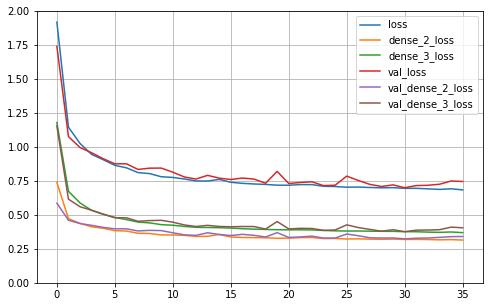

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 2)
    plt.show()
plot_learning_curves(history)

In [9]:
model.evaluate([x_test_scaled_wide, x_test_scaled_deep],
               [y_test, y_test], verbose=0)

[0.7420355081558228, 0.3427351713180542, 0.39930030703544617]